In [2]:
!pip install image-reward
!pip install torch torchvision
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yctiivfg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yctiivfg
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import clip
import matplotlib.pyplot as plt
import os
from PIL import Image
# Import additional libraries if needed for ImageReward


/home/guest0/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install torch torchvision
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import os

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-kqgxgr9o
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-kqgxgr9o
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable


In [5]:
import ImageReward


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
image_reward_model = ImageReward.load("ImageReward-v1.0")


load checkpoint from /home/guest0/.cache/ImageReward/ImageReward.pt
checkpoint loaded


In [7]:
def extract_batch_number(filename):
    # Extract the batch number from the filename
    # Assuming the batch number is preceded by 'batch_' in the filename
    batch_part = filename.split('batch_')[-1]  # This splits the string at 'batch_' and takes the last part
    batch_num = batch_part.split('_')[0]  # This gets the number after 'batch_'
    return batch_num

In [8]:

def calculate_clip_scores(image_directory, text_prompt):
    text = clip.tokenize([text_prompt]).to(device)
    clip_scores = []
    for filename in sorted(os.listdir(image_directory)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_directory, filename)
            image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(image)
                text_features = clip_model.encode_text(text)
                similarity = torch.cosine_similarity(text_features, image_features).cpu().numpy()[0]
                clip_scores.append(similarity)
    return clip_scores


def calculate_image_reward_scores(image_directory, text_prompt):
    image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory) 
                   if f.endswith('.jpg') or f.endswith('.png')]
    try:
        scores = image_reward_model.score(text_prompt, image_paths)
        return scores
    except Exception as e:
        print(f"Error in calculating ImageReward scores: {e}")
        return []


In [9]:
def process_folders(base_path, score_function):
    batch_scores = {}
    for animal in os.listdir(base_path):
        animal_folder = os.path.join(base_path, animal)
        if os.path.isdir(animal_folder):
            text_prompt = animal  # Using animal name as prompt
            scores = score_function(animal_folder, text_prompt)
            for i, filename in enumerate(sorted(os.listdir(animal_folder))):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    batch_num = extract_batch_number(filename)
                    batch_scores.setdefault(batch_num, []).append(scores[i])
    # Calculate average score for each batch
    average_scores = {batch: sum(scores)/len(scores) for batch, scores in batch_scores.items() if scores}
    return average_scores


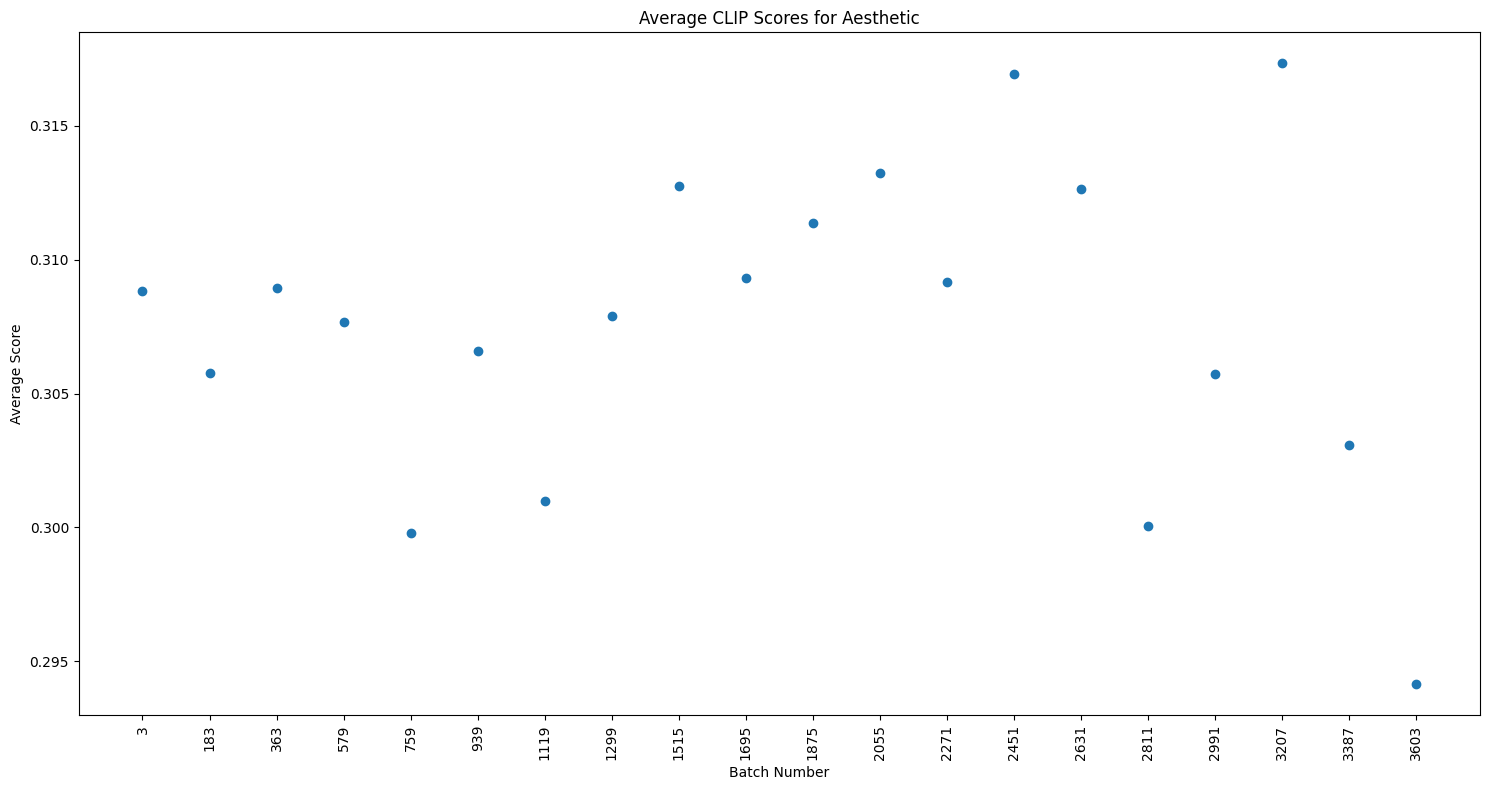

In [10]:
def plot_scores(scores, title):
    plt.figure(figsize=(15, 8))  # Increased figure size for better readability
    # Sort the scores by batch number, ensuring we convert the batch numbers to integers
    batches = sorted(scores.keys(), key=lambda x: int(extract_batch_number(x)))
    avg_scores = [scores[batch] for batch in batches]
    plt.scatter(batches, avg_scores)
    plt.xlabel('Batch Number')
    plt.ylabel('Average Score')
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate the labels to make them vertical
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.show()

# Make sure to also adjust the `process_folders` function accordingly:
def process_folders(base_path, score_function):
    batch_scores = {}
    for animal in os.listdir(base_path):
        animal_folder = os.path.join(base_path, animal)
        if os.path.isdir(animal_folder):
            text_prompt = animal  # Using animal name as prompt
            scores = score_function(animal_folder, text_prompt)
            for i, filename in enumerate(sorted(os.listdir(animal_folder))):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    batch_num = extract_batch_number(filename)
                    batch_scores.setdefault(batch_num, []).append(scores[i])
    # Calculate average score for each batch
    average_scores = {batch: sum(scores)/len(scores) for batch, scores in batch_scores.items() if scores}
    return average_scores

# Continue with the evaluation and plotting as before
aesthetic_clip_scores = process_folders('/home/guest0/Eval/imagesgenerated/Aesthetic', calculate_clip_scores)
plot_scores(aesthetic_clip_scores, 'Average CLIP Scores for Aesthetic')

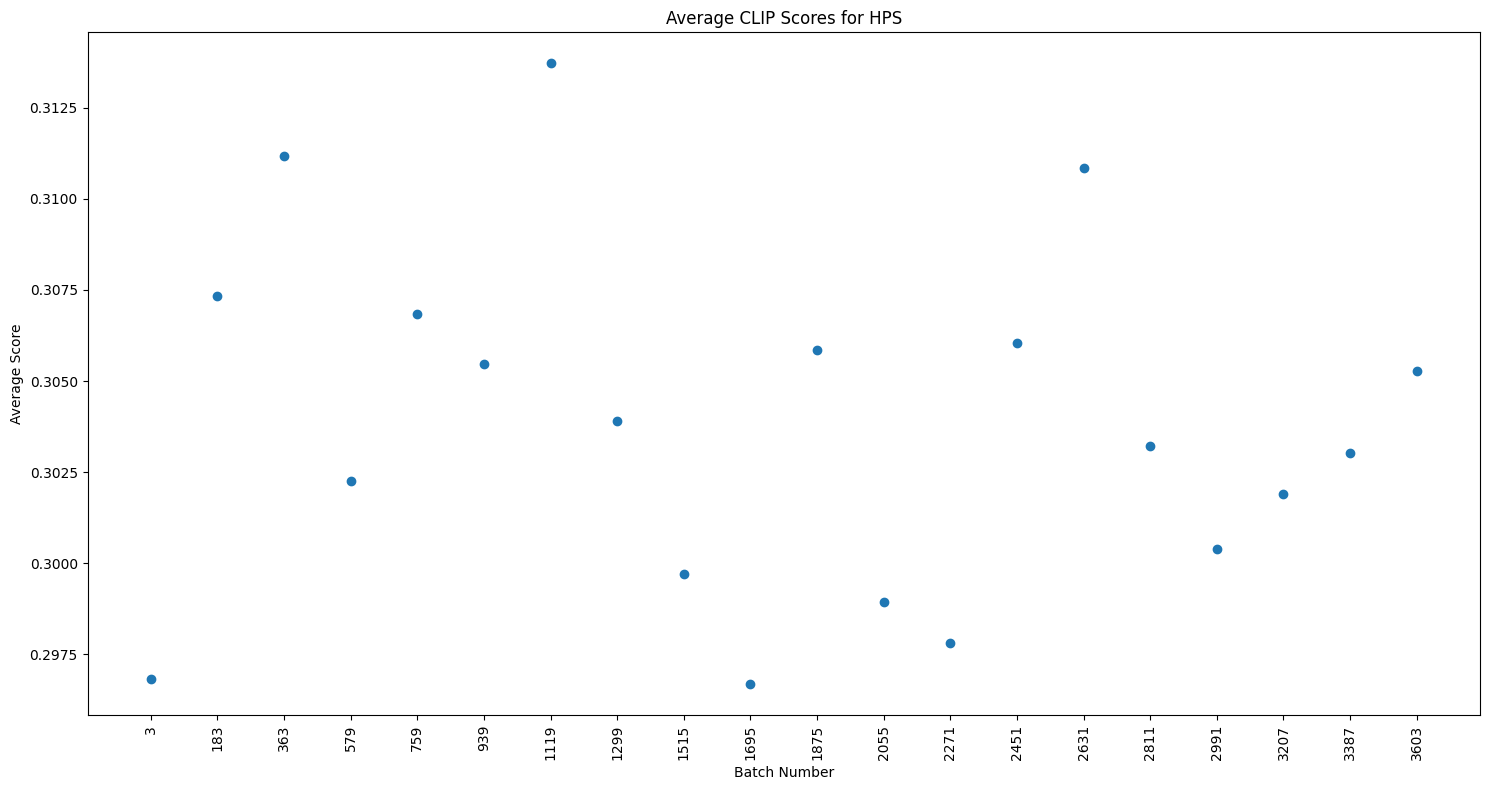

In [11]:
# Calculate and plot CLIP scores for the HPS dataset
hps_clip_scores = process_folders('/home/guest0/Eval/imagesgenerated/HPS', calculate_clip_scores)
plot_scores(hps_clip_scores, 'Average CLIP Scores for HPS')

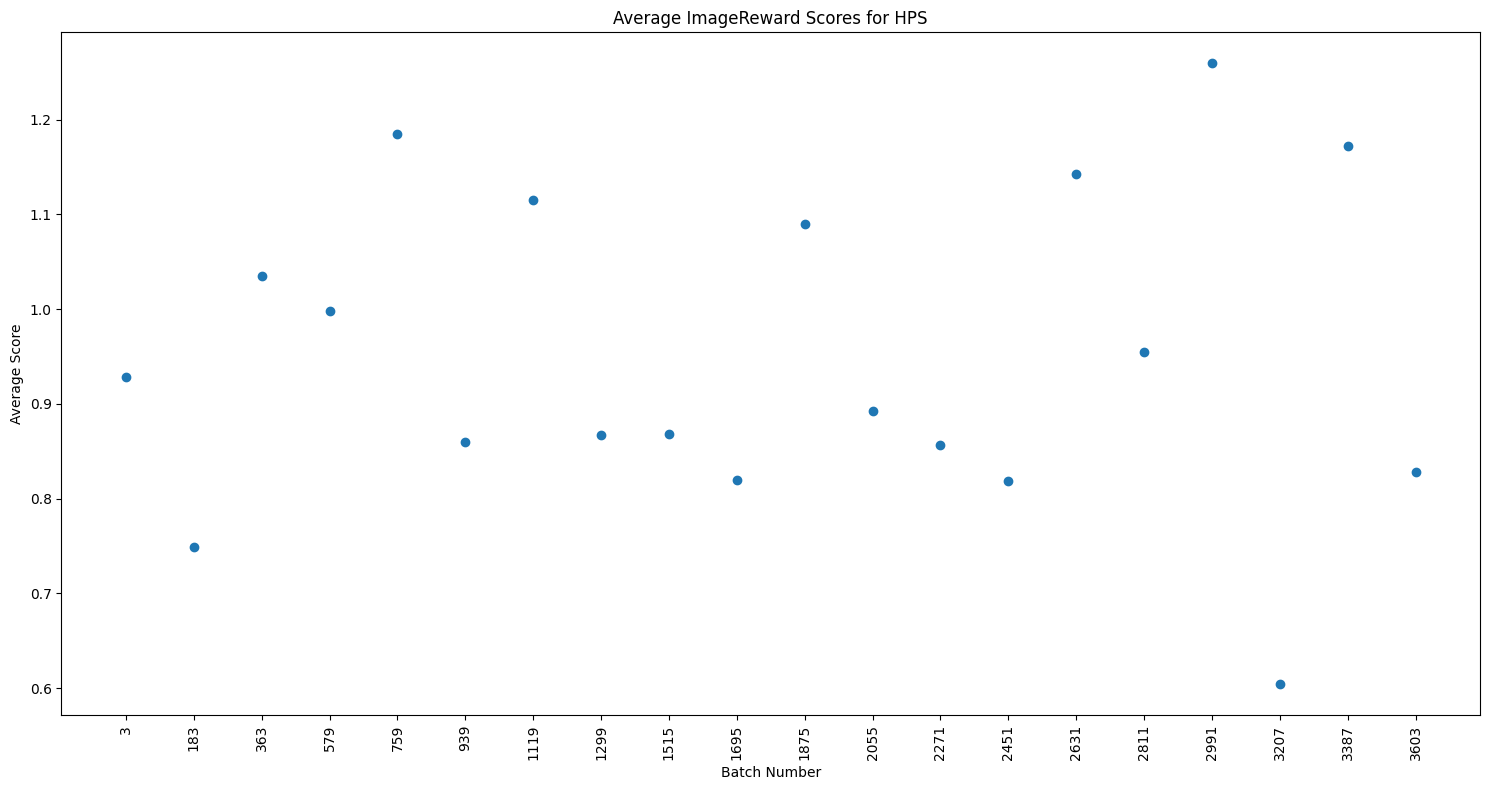

In [12]:
hps_image_reward_scores = process_folders('/home/guest0/Eval/imagesgenerated/HPS', calculate_image_reward_scores)
plot_scores(hps_image_reward_scores, 'Average ImageReward Scores for HPS')


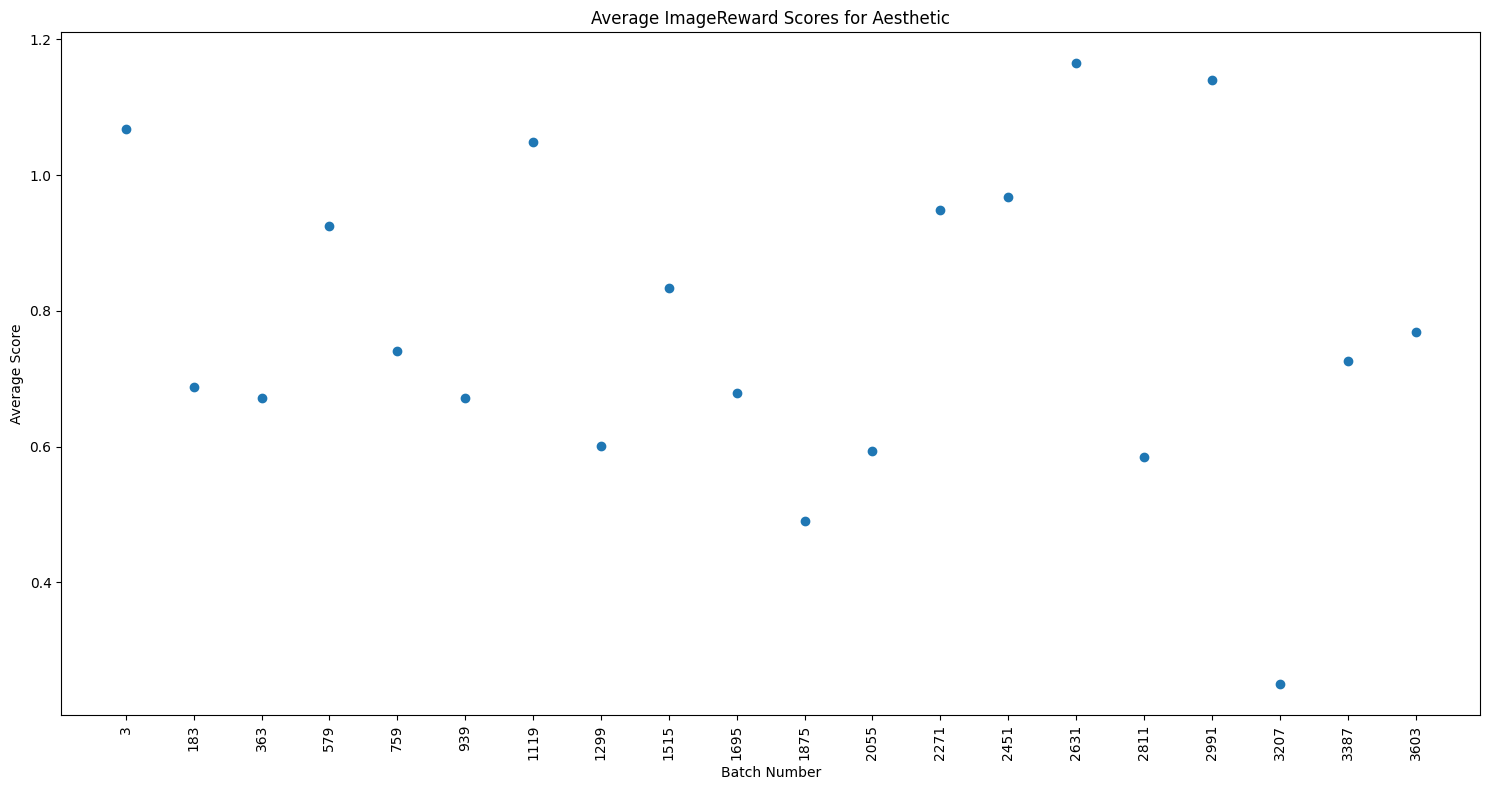

In [13]:
aesthetic_image_reward_scores = process_folders('/home/guest0/Eval/imagesgenerated/Aesthetic', calculate_image_reward_scores)
plot_scores(aesthetic_image_reward_scores, 'Average ImageReward Scores for Aesthetic')


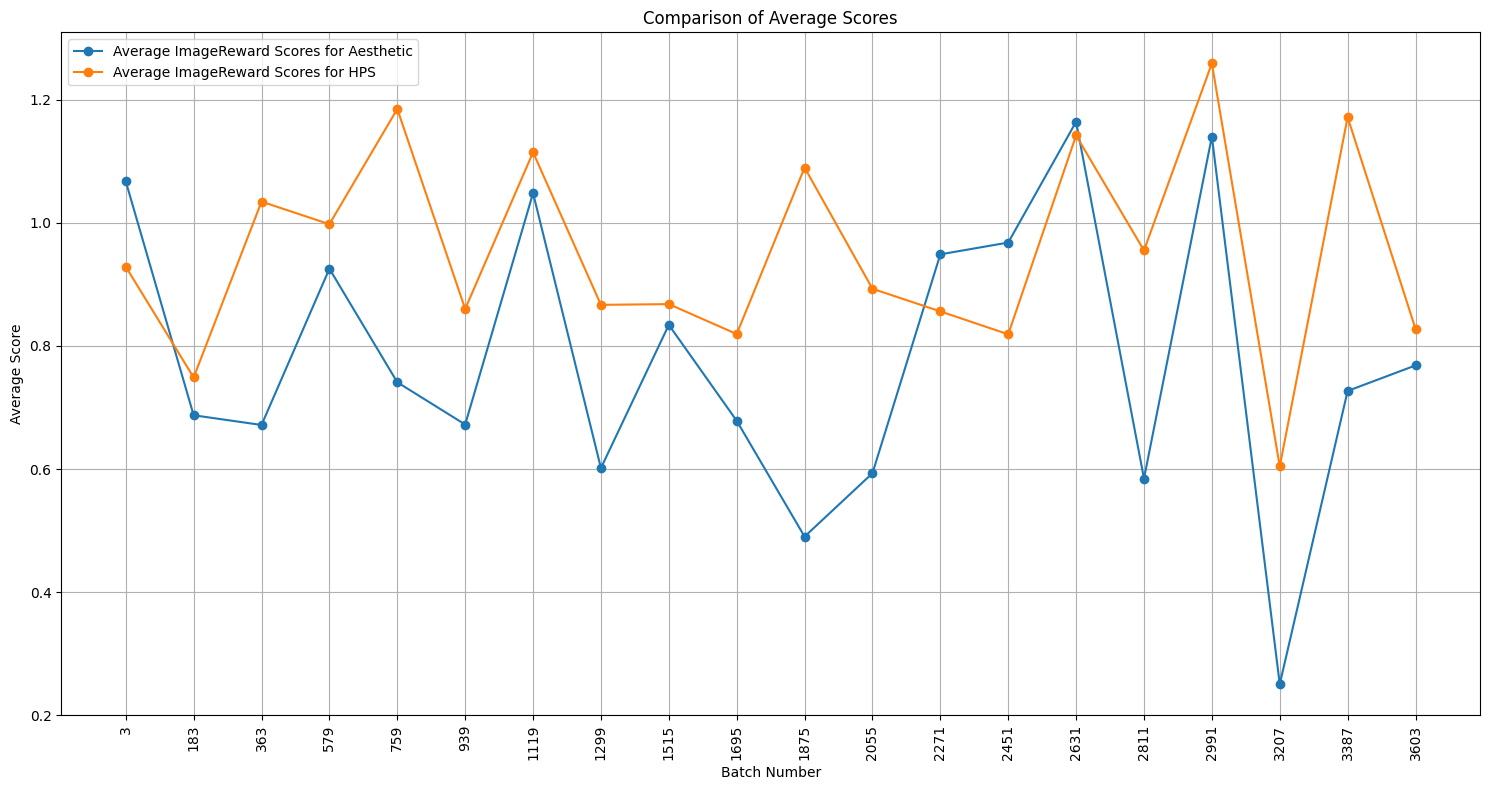

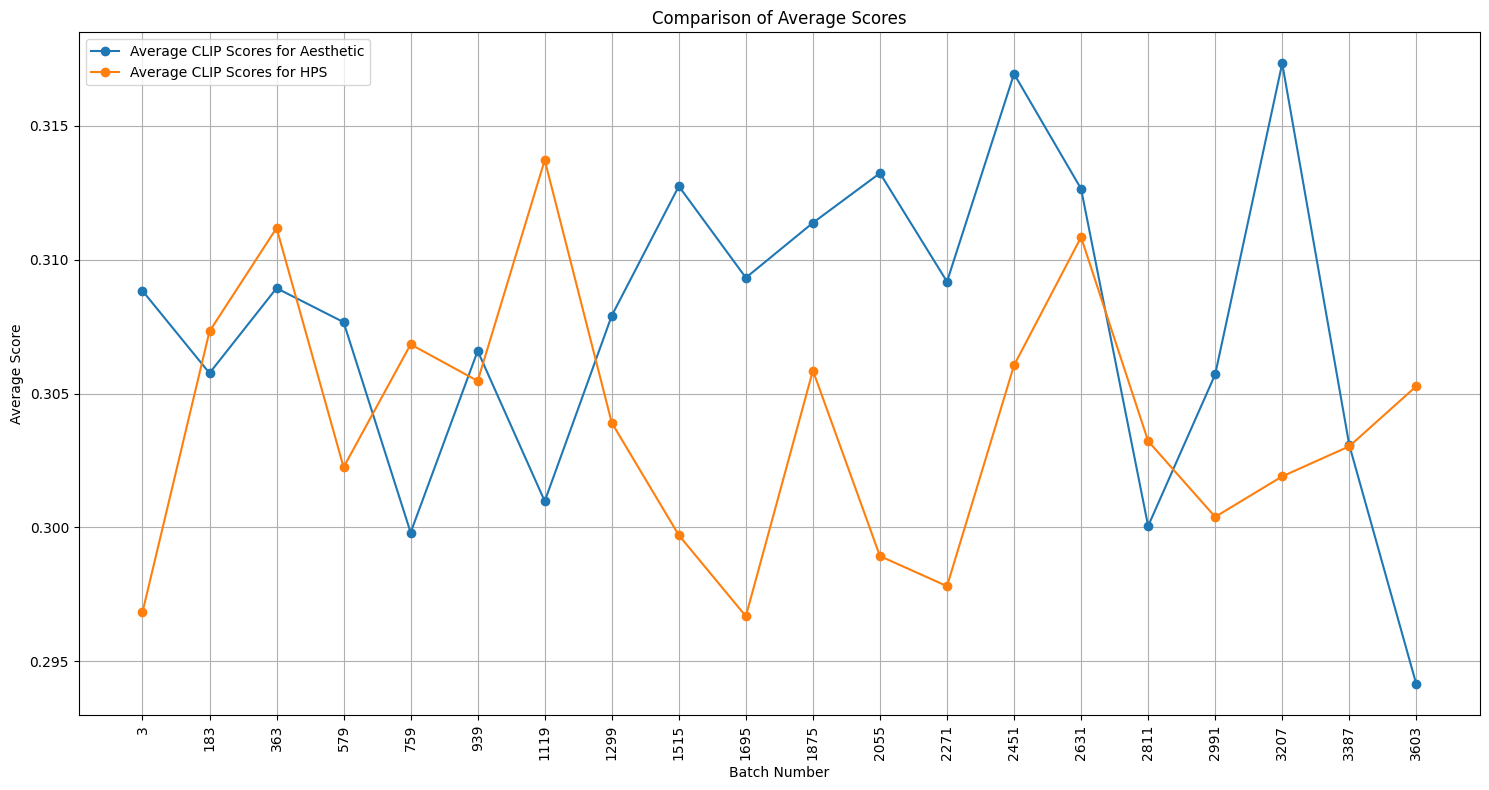

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scores(scores1, scores2, title1, title2):
    plt.figure(figsize=(15, 8))  # Increased figure size for better readability

    # Sort and prepare the scores for Aesthetic
    batches1 = sorted(scores1.keys(), key=lambda x: int(extract_batch_number(x)))
    avg_scores1 = [scores1[batch] for batch in batches1]

    # Sort and prepare the scores for HPS
    batches2 = sorted(scores2.keys(), key=lambda x: int(extract_batch_number(x)))
    avg_scores2 = [scores2[batch] for batch in batches2]

    # Create a line plot for Aesthetic and HPS
    plt.plot(batches1, avg_scores1, label=title1, marker='o')
    plt.plot(batches2, avg_scores2, label=title2, marker='o')

    # Add labels, title, and legend
    plt.xlabel('Batch Number')
    plt.ylabel('Average Score')
    plt.title('Comparison of Average Scores')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate the labels to make them vertical
    plt.tight_layout()  # Adjust layout to fit everything nicely
    plt.grid(True)
    plt.show()

# Example usage for ImageReward scores
plot_scores(aesthetic_image_reward_scores, hps_image_reward_scores, 
            'Average ImageReward Scores for Aesthetic', 'Average ImageReward Scores for HPS')

# You would repeat the plotting for CLIP scores in a similar way
plot_scores(aesthetic_clip_scores, hps_clip_scores, 
            'Average CLIP Scores for Aesthetic', 'Average CLIP Scores for HPS')


In [15]:
import numpy as np
# Assuming calculate_image_reward_scores is defined and works as expected
hps_image_reward_scores = process_folders('/home/guest0/Eval/imagesgenerated/HPS', calculate_image_reward_scores)
aesthetic_image_reward_scores = process_folders('/home/guest0/Eval/imagesgenerated/Aesthetic', calculate_image_reward_scores)

def compute_statistics(scores):
    # Flatten scores if they are in lists, or just aggregate them directly if they are not
    all_scores = []
    for score in scores.values():
        if isinstance(score, list):
            all_scores.extend(score)
        else:
            all_scores.append(score)

    mean = np.mean(all_scores)
    std_dev = np.std(all_scores)

    # Sorting all scores to find top 5 and worst 5
    sorted_scores = sorted(all_scores)

    # Calculating statistics for the top 5 and worst 5 scores
    # If there are less than 5 scores, handle appropriately
    if len(sorted_scores) >= 5:
        top_5 = sorted_scores[-5:]
        worst_5 = sorted_scores[:5]
    else:
        # If less than 5 scores, use all available scores for top and worst calculations
        top_5 = sorted_scores
        worst_5 = sorted_scores

    top_5_mean = np.mean(top_5)
    top_5_std = np.std(top_5)
    worst_5_mean = np.mean(worst_5)
    worst_5_std = np.std(worst_5)

    return mean, std_dev, top_5_mean, top_5_std, worst_5_mean, worst_5_std




def print_statistics_table(statistics_ours, statistics_sota):
    print(f"{'Metric':<30} {'Ours':<20} {'SOTA':<20}")
    print(f"{'Average Score:':<30} {statistics_ours[0]:.2f} ± {statistics_ours[1]:.2f} {statistics_sota[0]:.2f} ± {statistics_sota[1]:.2f}")
    print(f"{'Average Score for Top 5:':<30} {statistics_ours[2]:.2f} ± {statistics_ours[3]:.2f} {statistics_sota[2]:.2f} ± {statistics_sota[3]:.2f}")
    print(f"{'Average Score for Worst 5:':<20} {statistics_ours[4]:.2f} +- {statistics_ours[5]:.2f}    {statistics_sota[4]:.2f} +- {statistics_sota[5]:.2f}")


# Calculate statistics for both models
statistics_sota = compute_statistics(aesthetic_image_reward_scores)
statistics_ours = compute_statistics(hps_image_reward_scores)

# Print the statistics table
print_statistics_table(statistics_ours, statistics_sota)



Metric                         Ours                 SOTA                
Average Score:                 0.95 ± 0.16 0.78 ± 0.23
Average Score for Top 5:       1.17 ± 0.05 1.08 ± 0.07
Average Score for Worst 5: 0.76 +- 0.08    0.50 +- 0.13


In [16]:
import numpy as np
# Assuming calculate_image_reward_scores is defined and works as expected

hps_clip_scores = process_folders('/home/guest0/Eval/imagesgenerated/HPS', calculate_clip_scores)
aesthetic_clip_scores = process_folders('/home/guest0/Eval/imagesgenerated/Aesthetic', calculate_clip_scores)

def compute_statistics(scores):
    # Flatten scores if they are in lists, or just aggregate them directly if they are not
    all_scores = []
    for score in scores.values():
        if isinstance(score, list):
            all_scores.extend(score)
        else:
            all_scores.append(score)

    mean = np.mean(all_scores)
    std_dev = np.std(all_scores)

    # Sorting all scores to find top 5 and worst 5
    sorted_scores = sorted(all_scores)

    # Calculating statistics for the top 5 and worst 5 scores
    # If there are less than 5 scores, handle appropriately
    if len(sorted_scores) >= 5:
        top_5 = sorted_scores[-5:]
        worst_5 = sorted_scores[:5]
    else:
        # If less than 5 scores, use all available scores for top and worst calculations
        top_5 = sorted_scores
        worst_5 = sorted_scores

    top_5_mean = np.mean(top_5)
    top_5_std = np.std(top_5)
    worst_5_mean = np.mean(worst_5)
    worst_5_std = np.std(worst_5)

    return mean, std_dev, top_5_mean, top_5_std, worst_5_mean, worst_5_std




def print_statistics_table(statistics_ours, statistics_sota):
    print(f"{'Metric':<30} {'Ours':<20} {'SOTA':<20}")
    print(f"{'Average Score:':<30} {statistics_ours[0]:.4f} ± {statistics_ours[1]:.4f} {statistics_sota[0]:.4f} ± {statistics_sota[1]:.4f}")
    print(f"{'Average Score for Top 5:':<30} {statistics_ours[2]:.4f} ± {statistics_ours[3]:.4f} {statistics_sota[2]:.4f} ± {statistics_sota[3]:.4f}")
    print(f"{'Average Score for Worst 5:':<30} {statistics_ours[4]:.4f} ± {statistics_ours[5]:.4f} {statistics_sota[4]:.4f} ± {statistics_sota[5]:.4f}")


# Calculate statistics for both models
statistics_sota = compute_statistics(aesthetic_clip_scores)
statistics_ours = compute_statistics(hps_clip_scores)

# Print the statistics table
print_statistics_table(statistics_ours, statistics_sota)


Metric                         Ours                 SOTA                
Average Score:                 0.3039 ± 0.0047 0.3076 ± 0.0057
Average Score for Top 5:       0.3100 ± 0.0026 0.3146 ± 0.0021
Average Score for Worst 5:     0.2980 ± 0.0012 0.2996 ± 0.0030


In [17]:
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
import numpy as np
from scipy.linalg import sqrtm
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_features(model, image_paths):
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    model.eval()
    features = []
    with torch.no_grad():
        for img_path in image_paths:
            img = Image.open(img_path).convert("RGB")
            img = preprocess(img).unsqueeze(0).to(device)
            feature = model(img)[0].view(-1).cpu().numpy()
            features.append(feature)
    return np.array(features)

def calculate_fid(real_features, gen_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0]
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def load_images_from_folder(folder, max_images=10):
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.png', '.jpg'))]
    return images[:max_images]

# Load Inception v3 model
inception_model = inception_v3(pretrained=True).to(device)

# Directories
generated_images_base_dir = "/home/guest0/Eval/imagesgenerated/Aesthetic"
imagenet_images_base_dir = "/home/guest0/Eval/imagesgenerated/Real_Image"

animals = ['bald eagle', 'beagle', 'panda', 'Sealyham terrier', 'tiger']  # Replace with actual animal names

for animal in animals:
    gen_images_dir = os.path.join(generated_images_base_dir, animal)
    imagenet_images_dir = os.path.join(imagenet_images_base_dir, animal)

    gen_images = load_images_from_folder(gen_images_dir)
    real_images = load_images_from_folder(imagenet_images_dir)

    gen_features = get_features(inception_model, gen_images)
    real_features = get_features(inception_model, real_images)

    fid_score = calculate_fid(real_features, gen_features)
    print(f"FID Score for {animal}: {fid_score}")



FID Score for bald eagle: 101.789794921875
FID Score for beagle: 2251799813685489.0
FID Score for panda: -2111062325329822.0
FID Score for Sealyham terrier: 2.9514790517935283e+20
FID Score for tiger: -1.1805916207174113e+21
